### Imports

In [31]:
#from backtesting.test import EURUSD, GOOG

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [32]:
PERIOD = 24

### Process parquet

In [33]:
import pandas as pd
import pyarrow.parquet as pq

DATA_PATH='/home/bkadmin/datasets/spatialedge-hackathon-H1/v1/' 
FROM_DATE='20170120'
TO_DATE='20180420'
SYMBOL = 'EURUSD'
TIMEFRAME = 'H1'

def read_and_process_parquet(data_path, from_date, to_date, symbol, timeframe):
    partition = ['symbol','timeframe', 'date', 'date']
    operator = ['=', '=', '>=', '<=']
    params = [symbol, timeframe, from_date, to_date]
            
    dataset = pq.ParquetDataset(data_path, filters=list(zip(partition, operator, params)), use_legacy_dataset=True)
    table = dataset.read()
    df = table.to_pandas()

    df['date'] = df['date'].astype(str)
    df['time'] = df['time'].astype(str)

    df['datetime'] = df['date'] + ' ' + df['time']
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S')
    df.set_index('datetime', inplace=True)

    df.drop(['time', 'symbol', 'timeframe', 'date'], axis=1, inplace=True)
    df = df.sort_values('datetime')
    df.fillna(method='ffill', inplace=True)

    return df 

data = read_and_process_parquet(DATA_PATH, FROM_DATE, TO_DATE, SYMBOL, TIMEFRAME)

/tmp/ipykernel_187506/3117672506.py:15: FutureWarning: Passing 'use_legacy_dataset=True' to get the legacy behaviour is deprecated as of pyarrow 11.0.0, and the legacy implementation will be removed in a future version.
  dataset = pq.ParquetDataset(data_path, filters=list(zip(partition, operator, params)), use_legacy_dataset=True)


### Create helper functions

In [34]:
# Relative Strength Index (RSI)
def RSI(values, period=168):
    delta = pd.Series(values).diff()
    gain = delta.where(delta>0.0)
    #gain.fillna(0, inplace=True) 
    loss = -delta.where(delta<0.0)
    #loss.fillna(0, inplace=True) 
    # #TODO: instead of replacing with 0, remove those vaues
    avg_gain = gain.rolling(period, min_periods=1).mean() # average gain over 7 day period (168hr) 
    avg_gain.fillna(0, inplace=True)
    avg_loss = loss.rolling(period, min_periods=1).mean() # average loss over 7 day period (168hr)
    avg_loss.fillna(0.000000001, inplace=True)
    rs = (avg_gain/avg_loss)
    rsi = 100-(100/(1+rs))

    return rsi



def Stochastic_Oscillator(values, period=168):
    '''Calculates stochastic oscillator'''
    time_period = period
    data = pd.Series(values)
    if len(values) < time_period:
        time_period = len(values)
    lowest_close_in_period = data.rolling(time_period, min_periods=1).min()
    highest_close_in_period = data.rolling(time_period, min_periods=1).max()
    so = ((data-lowest_close_in_period)/(highest_close_in_period-lowest_close_in_period))*100
    return so


def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


### Create features

In [35]:
from feature_engine.timeseries.forecasting import LagFeatures
import numpy as np
import pandas_ta as ta

# Simple Moving Average
def SMA(values, n):
    return pd.Series(values).rolling(n).mean()

day = 24
month = 30 * day
year = (365.2425) * day

data.columns = ['Open','High','Low','Close','Volume']
open, low, high, close = data.Open, data.Low, data.High, data.Close 

data['X_RSI'] = ta.rsi(close, PERIOD * 14)
# data.ta.stoch(high='High', low='Low', close='Close', k=PERIOD * 14, d=PERIOD * 3, append=True) 

data['X_SMA1']  = SMA(close, PERIOD)
data['X_SMA14'] = SMA(close, PERIOD * 14)
data['X_SMA28'] = SMA(close, PERIOD * 28)
data['X_SMA56'] = SMA(close, PERIOD * 56)

# Time indicators
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data['X_Day_Sin'] = np.sin(data.index.hour * (2 * np.pi / day))
data['X_Day_Cos'] = np.cos(data.index.hour * (2 * np.pi / day))
data['X_Day_Tan'] = np.tan(data.index.hour * (2 * np.pi / day))

data['X_Day_Sin'] = np.sin(data.index.day * (2 * np.pi / month))
data['X_Day_Cos'] = np.cos(data.index.day * (2 * np.pi / month))
data['X_Day_Tan'] = np.tan(data.index.day * (2 * np.pi / month))

data['X_Year_Sin'] = np.sin(data.index.dayofyear * (2 * np.pi / year))
data['X_Year_Cos'] = np.cos(data.index.dayofyear * (2 * np.pi / year))
data['X_Year_Tan'] = np.tan(data.index.dayofyear * (2 * np.pi / year))

data['X_MOM'] = data.Close.pct_change(periods=PERIOD * 2)
data['X_BB_UP'] = SMA(close, PERIOD * 14) + (2 * ta.stdev(close, PERIOD * 14))
data['X_BB_LOW'] = SMA(close, PERIOD * 14) - (2 * ta.stdev(close, PERIOD * 14))

data

,Open,High,Low,Close,Volume,X_RSI,X_SMA1,X_SMA14,X_SMA28,X_SMA56,...,X_hour,X_Day_Sin,X_Day_Cos,X_Day_Tan,X_Year_Sin,X_Year_Cos,X_Year_Tan,X_MOM,X_BB_UP,X_BB_LOW
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-20 00:00:00,1.065950,1.066185,1.065235,1.065380,9585.639978,NaN,NaN,NaN,NaN,NaN,...,0,0.173648,0.984808,0.176327,0.014335,0.999897,0.014337,NaN,NaN,NaN
2017-01-20 01:00:00,1.065375,1.068770,1.065375,1.068150,16217.679959,NaN,NaN,NaN,NaN,NaN,...,1,0.173648,0.984808,0.176327,0.014335,0.999897,0.014337,NaN,NaN,NaN
2017-01-20 02:00:00,1.068160,1.068380,1.067490,1.067730,10407.969949,NaN,NaN,NaN,NaN,NaN,...,2,0.173648,0.984808,0.176327,0.014335,0.999897,0.014337,NaN,NaN,NaN
2017-01-20 03:00:00,1.067740,1.069360,1.067740,1.068530,12398.809963,NaN,NaN,NaN,NaN,NaN,...,3,0.173648,0.984808,0.176327,0.014335,0.999897,0.014337,NaN,NaN,NaN
2017-01-20 04:00:00,1.068510,1.068590,1.067825,1.068020,7931.159967,NaN,NaN,NaN,NaN,NaN,...,4,0.173648,0.984808,0.176327,0.014335,0.999897,0.014337,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-20 16:00:00,1.228185,1.230020,1.228020,1.229680,22823.450088,49.186188,1.232367,1.232496,1.233251,1.233735,...,16,0.173648,0.984808,0.176327,0.078764,0.996893,0.079010,-0.007538,1.241340,1.223651
2018-04-20 17:00:00,1.229660,1.229680,1.228655,1.228675,15033.920076,48.961691,1.232121,1.232490,1.233235,1.233720,...,17,0.173648,0.984808,0.176327,0.078764,0.996893,0.079010,-0.007733,1.241342,1.223639
2018-04-20 18:00:00,1.228675,1.228995,1.228195,1.228250,14483.680033,48.867089,1.231890,1.232485,1.233218,1.233703,...,18,0.173648,0.984808,0.176327,0.078764,0.996893,0.079010,-0.007671,1.241344,1.223625


In [36]:
# Lagging price indicator
#data['X_LAG1'] = data.Close.shift(24)
lf = LagFeatures(periods=PERIOD, variables = ["Close"])
data.index.value_counts()

2017-03-13 00:00:00    2
2018-03-12 00:00:00    2
2017-01-20 00:00:00    1
2017-11-20 10:00:00    1
2017-11-20 22:00:00    1
                      ..
2017-06-21 02:00:00    1
2017-06-21 01:00:00    1
2017-06-21 00:00:00    1
2017-06-20 23:00:00    1
2018-04-20 20:00:00    1
Name: datetime, Length: 7796, dtype: int64

In [37]:
data = data[~data.index.duplicated(keep='first')]
data.index.value_counts()

2017-01-20 00:00:00    1
2017-11-17 19:00:00    1
2017-11-20 23:00:00    1
2017-11-20 22:00:00    1
2017-11-20 21:00:00    1
                      ..
2017-06-21 01:00:00    1
2017-06-21 00:00:00    1
2017-06-20 23:00:00    1
2017-06-20 22:00:00    1
2018-04-20 20:00:00    1
Name: datetime, Length: 7796, dtype: int64

In [38]:
data = lf.fit_transform(data)
data = data.dropna()
data.dropna().astype(float)

,Open,High,Low,Close,Volume,X_RSI,X_SMA1,X_SMA14,X_SMA28,X_SMA56,...,X_Day_Sin,X_Day_Cos,X_Day_Tan,X_Year_Sin,X_Year_Cos,X_Year_Tan,X_MOM,X_BB_UP,X_BB_LOW,Close_lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2017-04-09 22:00:00,1.058365,1.058565,1.057865,1.057900,8331.419980,47.209241,1.062245,1.073932,1.068185,1.067344,...,0.078459,0.996917,0.078702,0.070902,0.997483,0.071081,-0.008431,1.089401,1.058462,1.064310
2017-04-09 23:00:00,1.057890,1.058280,1.057360,1.058065,9285.059961,47.252499,1.061981,1.073885,1.068188,1.067338,...,0.078459,0.996917,0.078702,0.070902,0.997483,0.071081,-0.008546,1.089451,1.058319,1.064400
2017-04-10 00:00:00,1.058075,1.058340,1.057635,1.057710,10870.099938,47.169091,1.061701,1.073831,1.068189,1.067331,...,0.087156,0.996195,0.087489,0.071617,0.997432,0.071801,-0.009324,1.089494,1.058167,1.064430
2017-04-10 01:00:00,1.057720,1.058560,1.057620,1.057845,12185.629936,47.204636,1.061390,1.073775,1.068189,1.067323,...,0.087156,0.996195,0.087489,0.071617,0.997432,0.071801,-0.009328,1.089533,1.058017,1.065310
2017-04-10 02:00:00,1.057845,1.057910,1.057045,1.057595,9811.559961,47.145720,1.061106,1.073721,1.068191,1.067315,...,0.087156,0.996195,0.087489,0.071617,0.997432,0.071801,-0.009237,1.089576,1.057866,1.064430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-20 16:00:00,1.228185,1.230020,1.228020,1.229680,22823.450088,49.186188,1.232367,1.232496,1.233251,1.233735,...,0.173648,0.984808,0.176327,0.078764,0.996893,0.079010,-0.007538,1.241340,1.223651,1.234490
2018-04-20 17:00:00,1.229660,1.229680,1.228655,1.228675,15033.920076,48.961691,1.232121,1.232490,1.233235,1.233720,...,0.173648,0.984808,0.176327,0.078764,0.996893,0.079010,-0.007733,1.241342,1.223639,1.234595
2018-04-20 18:00:00,1.228675,1.228995,1.228195,1.228250,14483.680033,48.867089,1.231890,1.232485,1.233218,1.233703,...,0.173648,0.984808,0.176327,0.078764,0.996893,0.079010,-0.007671,1.241344,1.223625,1.233785


# Feature Importance

### Create matrix

In [39]:
def get_X(data):
    return data.filter(like='X').values

def get_y(data):
    y = data.Close.pct_change(PERIOD).shift(-PERIOD)
    y[y.between(-.005,.005)] = 0
    y[y > 0] = 1
    y[y < 0] = -1
    return y

def get_clean_Xy(df):
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

### Test model

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=0)

# Assuming y_train and X_train are both numpy arrays
data2 = np.column_stack((y_train, X_train))

# Xtrain
data2 = pd.Series(y_train) + pd.DataFrame(X_train) 

from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(penalty='l2', C=1.0)
model_lr.fit(X_train, y_train)

/home/bkadmin/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [41]:
column_names = tuple(data.columns[5:])

feature_importance = model_lr.coef_

feature_importance = np.abs(feature_importance)
feature_ranking = np.argsort(feature_importance)[0][::-1]

# Create a dictionary to store feature importances with their corresponding column names
feature_importance_dict = {column_name: importance for column_name, importance in zip(column_names, feature_importance[0])}
feature_importance_dict


{'X_RSI': 0.03238269379233445,
 'X_SMA1': 0.38322476674160894,
 'X_SMA14': 0.29882261585001163,
 'X_SMA28': 0.27824723046912186,
 'X_SMA56': 0.17684755310488695,
 'X_day': 0.012166084524232144,
 'X_hour': 0.0035716948223744886,
 'X_Day_Sin': 0.10566682677388205,
 'X_Day_Cos': 0.43164045408448926,
 'X_Day_Tan': 0.1107010414005881,
 'X_Year_Sin': 0.31529842117880824,
 'X_Year_Cos': 0.3732483995227449,
 'X_Year_Tan': 0.3268668455783218,
 'X_MOM': 0.0741295120643414,
 'X_BB_UP': 0.2924434930528751,
 'X_BB_LOW': 0.30520173864715744}

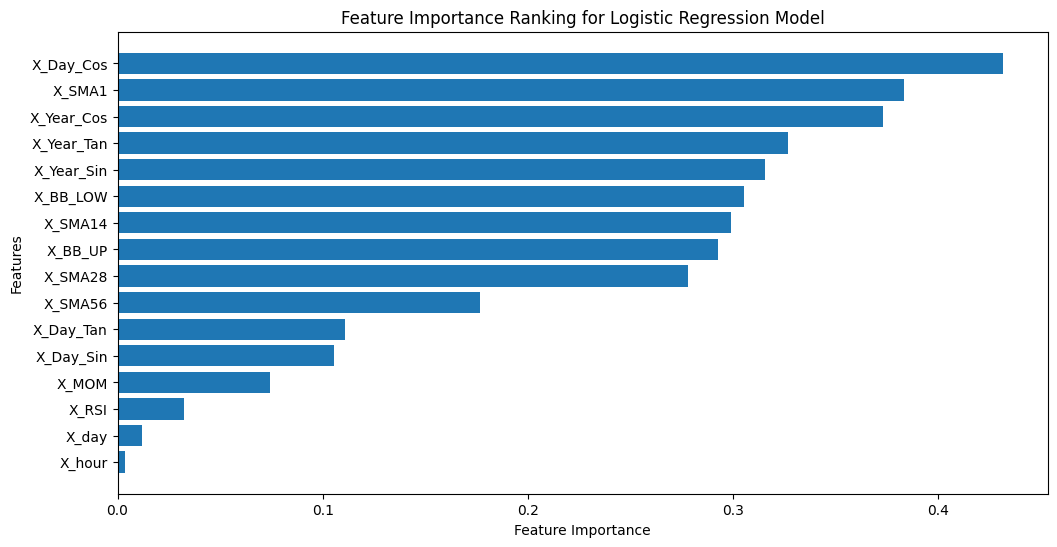

In [42]:
import matplotlib.pyplot as plt

# Sort feature importances in descending order
sorted_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the sorted feature names and importance scores
sorted_feature_names = [item[0] for item in sorted_importance]
sorted_importance_scores = [item[1] for item in sorted_importance]

# Create a bar plot to visualize the sorted feature importances
plt.figure(figsize=(12, 6))
plt.barh(sorted_feature_names, sorted_importance_scores)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Ranking for Logistic Regression Model')
plt.gca().invert_yaxis()
plt.show()



In [43]:
new_data = data.drop(sorted_feature_names[9:], axis='columns')

new_data

,Open,High,Low,Close,Volume,X_SMA1,X_SMA14,X_SMA28,X_Day_Cos,X_Year_Sin,X_Year_Cos,X_Year_Tan,X_BB_UP,X_BB_LOW,Close_lag_24
datetime,,,,,,,,,,,,,,,
2017-04-09 22:00:00,1.058365,1.058565,1.057865,1.057900,8331.419980,1.062245,1.073932,1.068185,0.996917,0.070902,0.997483,0.071081,1.089401,1.058462,1.064310
2017-04-09 23:00:00,1.057890,1.058280,1.057360,1.058065,9285.059961,1.061981,1.073885,1.068188,0.996917,0.070902,0.997483,0.071081,1.089451,1.058319,1.064400
2017-04-10 00:00:00,1.058075,1.058340,1.057635,1.057710,10870.099938,1.061701,1.073831,1.068189,0.996195,0.071617,0.997432,0.071801,1.089494,1.058167,1.064430
2017-04-10 01:00:00,1.057720,1.058560,1.057620,1.057845,12185.629936,1.061390,1.073775,1.068189,0.996195,0.071617,0.997432,0.071801,1.089533,1.058017,1.065310
2017-04-10 02:00:00,1.057845,1.057910,1.057045,1.057595,9811.559961,1.061106,1.073721,1.068191,0.996195,0.071617,0.997432,0.071801,1.089576,1.057866,1.064430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-20 16:00:00,1.228185,1.230020,1.228020,1.229680,22823.450088,1.232367,1.232496,1.233251,0.984808,0.078764,0.996893,0.079010,1.241340,1.223651,1.234490
2018-04-20 17:00:00,1.229660,1.229680,1.228655,1.228675,15033.920076,1.232121,1.232490,1.233235,0.984808,0.078764,0.996893,0.079010,1.241342,1.223639,1.234595
2018-04-20 18:00:00,1.228675,1.228995,1.228195,1.228250,14483.680033,1.231890,1.232485,1.233218,0.984808,0.078764,0.996893,0.079010,1.241344,1.223625,1.233785


In [44]:
#del X, y, X_train, X_test, y_train, y_test

#X, y = get_clean_Xy(new_data)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=0)

#model = DecisionTreeClassifier()

#model.fit(X_train,y_train)

#y_pred = model.predict(X_test)

#print('Classification accuracy: ', np.mean(y_test == y_pred))

#print(classification_report(y_test, y_pred))

#_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)


Classification accuracy:  0.9191290824261276
              precision    recall  f1-score   support

        -1.0       0.87      0.73      0.79       117
         0.0       0.93      0.97      0.95       974
         1.0       0.89      0.79      0.84       195

    accuracy                           0.92      1286
   macro avg       0.90      0.83      0.86      1286
weighted avg       0.92      0.92      0.92      1286



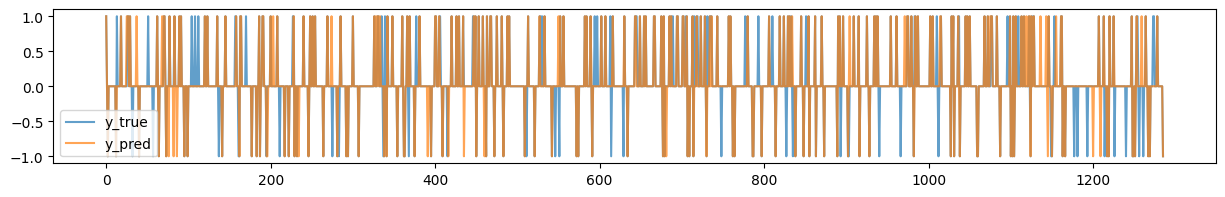

In [45]:
clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

clf.fit(X_train, y_train_encoded)

y_pred = clf.predict(X_test) - 1

print('Classification accuracy: ', np.mean(y_test == y_pred))
print(classification_report(y_test, y_pred))
_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)


### Strategy based on Relative Strength Index

In [58]:
from backtesting import Strategy, Backtest
from backtesting.lib import crossover

CASH = 100_000        
COMMISSION=0.001

# Importing 2018-06-01 to 2019-07-01
N_TRAIN = 24 * 180 # Training on a year of samples

class MLStrategy(Strategy):    
    price_delta = .006
    
    def init(self):
        #self.clf = DecisionTreeClassifier()
        
        self.clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

        df = self.data.df.iloc[:N_TRAIN]
        X,y = get_clean_Xy(df)

        # self.clf.fit(X,y)

        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y)
        self.clf.fit(X, y_train_encoded)

        self.tradecount = 0
        self.maxdaytrades = 2

        self.tpo = False
        self.I(get_y, self.data.df, name='y_true')

        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name = 'forecast')

    def next(self):
        if len(self.data) < N_TRAIN: return

        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        if current_time.hour == 0:
            self.tradecount = 0
        
        forecast = self.clf.predict(get_X(self.data.df.iloc[-1:])) 

        self.forecasts[-1] = forecast * 2 -1
        
        upper, lower = close[-1] * (1 + np.r_[1, -1] * self.price_delta)

        if forecast == 1 and not self.position.is_long and self.tradecount <= self.maxdaytrades:
            self.buy(size=.4, tp=upper, sl=lower)
            self.tradecount += 1
        elif forecast == -1 and not self.position.is_short and self.tradecount <= self.maxdaytrades:
            self.sell(size=.4, tp=lower, sl=upper)
            self.tradecount += 1

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        #for trade in self.trades:
        #    if current_time - trade.entry_time > pd.Timedelta('14 days'):
        #        if trade.is_long:
        #            trade.sl = max(trade.sl, low)
        #        else:
        #            trade.sl = min(trade.sl, high)

        #if self.equity > CASH*1.1: # If equity i500 ever 10% higher than starting cash, close position and cease trading
         #   self.position.close()
            #self.tpo=True        

### Backtest

In [59]:
bt = Backtest(new_data, MLStrategy, cash=CASH, commission=COMMISSION)
stats = bt.run()
stats

Start                     2017-04-09 22:00:00
End                       2018-04-20 20:00:00
Duration                    375 days 22:00:00
Exposure Time [%]                    8.428881
Equity Final [$]                101161.861468
Equity Peak [$]                 101342.944873
Return [%]                           1.161861
Buy & Hold Return [%]               16.149447
Return (Ann.) [%]                    0.905316
Volatility (Ann.) [%]                0.739722
Sharpe Ratio                         1.223859
Sortino Ratio                        2.105351
Calmar Ratio                         1.598064
Max. Drawdown [%]                   -0.566508
Avg. Drawdown [%]                   -0.105615
Max. Drawdown Duration       93 days 20:00:00
Avg. Drawdown Duration        4 days 20:00:00
# Trades                                   13
Win Rate [%]                        76.923077
Best Trade [%]                       0.502038
Worst Trade [%]                      -0.70054
Avg. Trade [%]                    

In [60]:
bt.plot()

/home/bkadmin/.local/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/home/bkadmin/.local/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p4059', ...)

Opening in existing browser session.
